In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import re
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [3]:
# download and unzip blocks manually because of its big size
zipurl = 'https://live.laborstats.alaska.gov/cen/maps/gis/Blocks2020.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('/tmp/Blocks2020')

In [17]:
# load shapefile from AK's Department of Labor and Workforce Development
# https://live.laborstats.alaska.gov/cen/maps-gis
boroughs = gpd.read_file("../Data/shapefiles/Boroughs2020/")
places = gpd.read_file("../Data/shapefiles/Places2020/") 
census_tracts = gpd.read_file("../Data/shapefiles/Tracts2020/")
block_groups = gpd.read_file("../Data/shapefiles/BlockGroups2020/")
blocks = gpd.read_file('/tmp/Blocks2020/')

# make column names lower case
boroughs.columns = map(str.lower, boroughs.columns)
places.columns = map(str.lower, places.columns)
census_tracts.columns = map(str.lower, census_tracts.columns)
block_groups.columns = map(str.lower, block_groups.columns)
blocks.columns = map(str.lower, blocks.columns)

In [5]:
places.crs

<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meters)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# Number of observations at each level
num_obs = [["boroughs", len(boroughs)],
           ["places", len(places)],
           ["census_tracts", len(census_tracts)],
           ["block_groups", len(block_groups)],
           ["blocks", len(blocks)]]

print(tabulate(num_obs, headers = ['Level of obs', 'N']))

Level of obs        N
--------------  -----
boroughs           30
places            355
census_tracts     177
block_groups      504
blocks          28568


In [7]:
# average stats at every level 
avg_stats = [["boroughs", len(boroughs), boroughs['totalpop'].mean(), boroughs['houseunits'].mean()],
             ["places", len(places), places['totalpop'].mean(), places['houseunits'].mean()],
             ["census_tracts", len(census_tracts), census_tracts['totalpop'].mean(), census_tracts['houseunits'].mean()],
             ["block_groups", len(block_groups), block_groups['totalpop'].mean(), block_groups['houseunits'].mean()],
             ["blocks", len(blocks), blocks['totalpop'].mean(), blocks['houseunits'].mean()]]

print(tabulate(avg_stats, headers=['Level of obs', 'N', 'Avg. pop', 'Avg. house units'], floatfmt=".0f"))

Level of obs        N    Avg. pop    Avg. house units
--------------  -----  ----------  ------------------
boroughs           30       24446               10873
places            355        2019                 881
census_tracts     177        4143                1843
block_groups      504        1455                 647
blocks          28568          26                  11


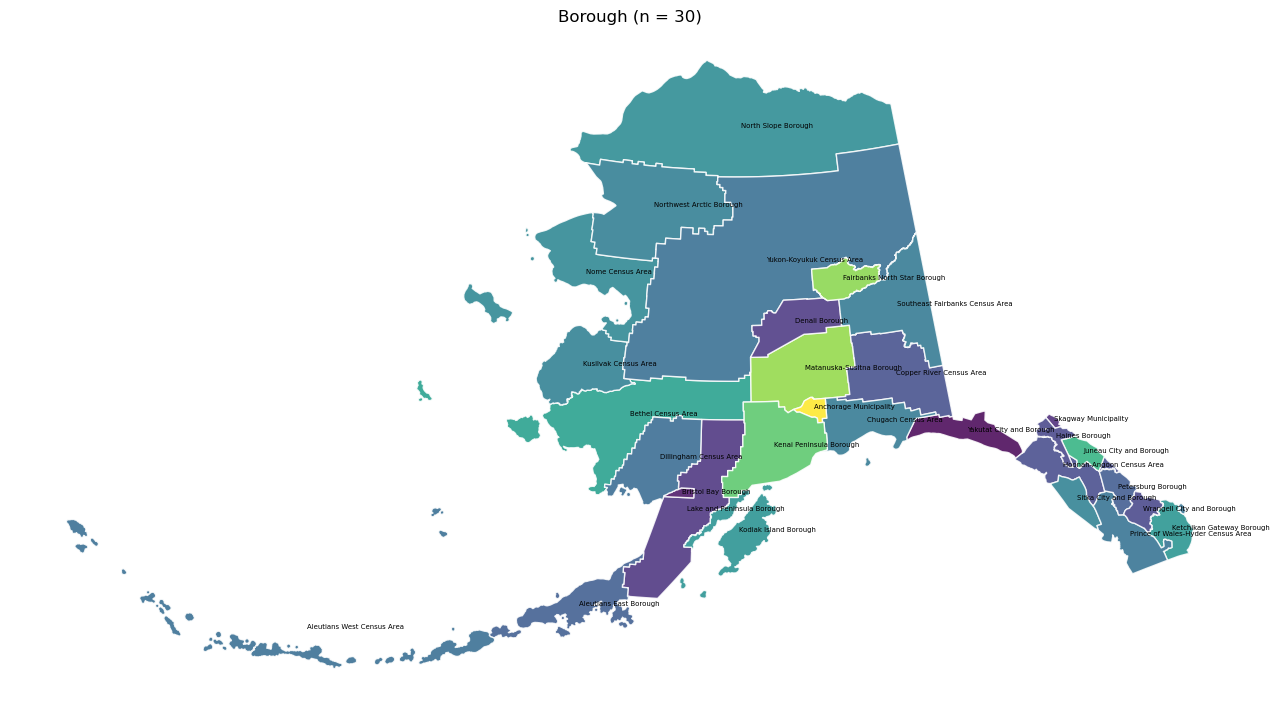

In [38]:
# visualize borough
boroughs['log_pop'] = np.log(boroughs.totalpop)
boroughs['centroid'] = boroughs['geometry'].centroid
boroughs_points = boroughs.copy()
boroughs_points.set_geometry("centroid", inplace = True)


fig, ax = plt.subplots(figsize=(16, 9))
boroughs.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor='white', alpha = 0.85)
ax.set_axis_off()

texts = []
for x, y, label in zip(boroughs_points.geometry.x, boroughs_points.geometry.y, boroughs_points["name"]):
    texts.append(plt.text(x, y, label, fontsize = 5))

plt.title("Borough (n = %s)" % len(boroughs))
#plt.savefig('../Output/Figures/boroughs_vis.png', dpi=1200)

Text(0.5, 1.0, 'Places (n = 355)')

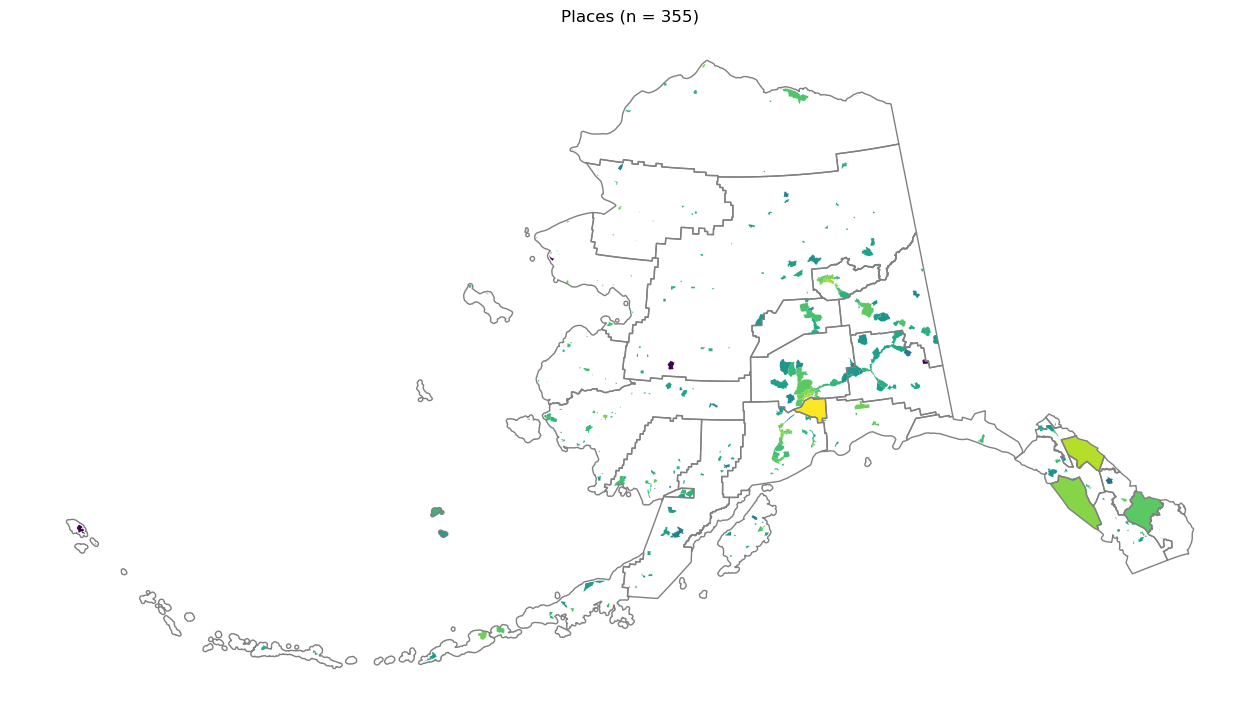

In [14]:
# visualize places
places['log_pop'] = np.log(places.totalpop + 0.001)

fig, ax = plt.subplots(figsize=(16, 9))
places.plot(ax = ax, column="log_pop", figsize=(16, 9))
boroughs.plot(ax = ax, facecolor='none', edgecolor='grey')
ax.set_axis_off()

plt.title("Places (n = %s)" % len(places))
#plt.savefig('../Output/Figures/places_vis.png', dpi=1200)

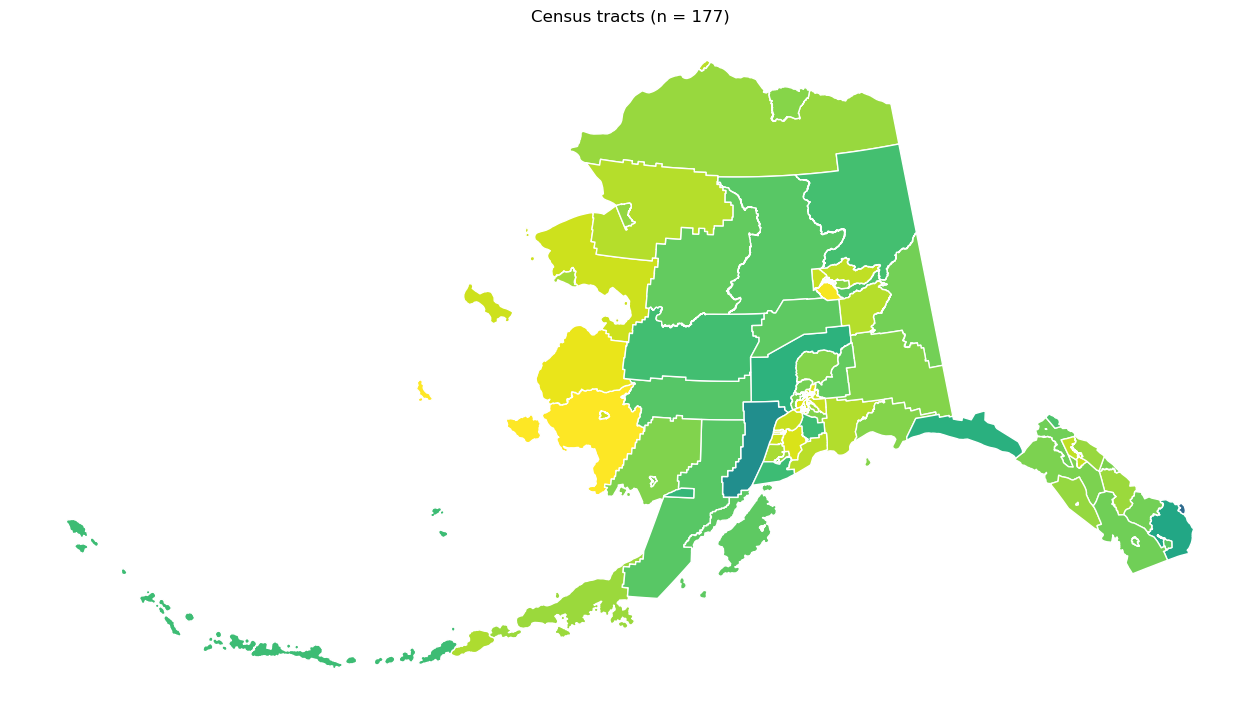

In [271]:
# visualize census tracts
census_tracts['log_pop'] = np.log(census_tracts.totalpop)
fig, ax = plt.subplots(figsize=(16, 9))
census_tracts.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor = 'white')
ax.set_axis_off()
plt.title("Census tracts (n = %s)" % len(census_tracts))
#plt.savefig('../Output/Figures/census_tracts.png', dpi=1200)

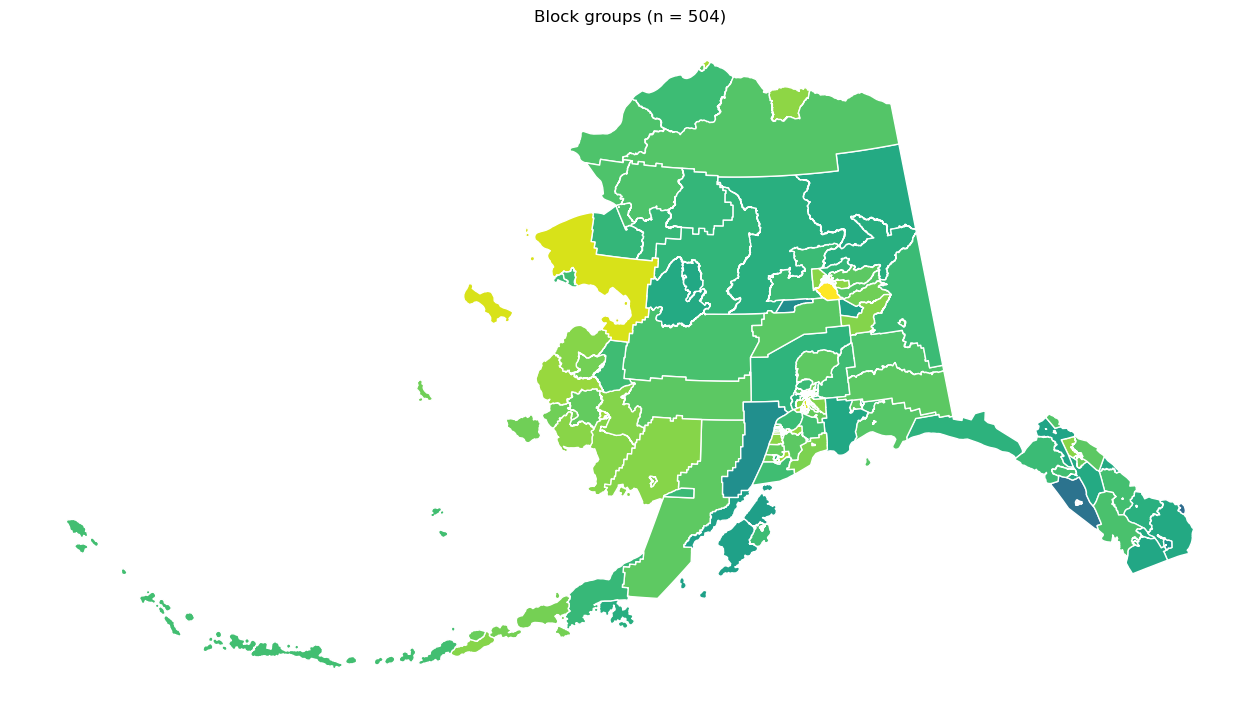

In [272]:
# visualize block_groups
block_groups['log_pop'] = np.log(block_groups.totalpop)
fig, ax = plt.subplots(figsize=(16, 9))
block_groups.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor = 'white')
ax.set_axis_off()
plt.title("Block groups (n = %s)" % len(block_groups))
#plt.savefig('../Output/Figures/block_groups.png', dpi=1200)

Text(0.5, 1.0, 'Block (n = 28568)')

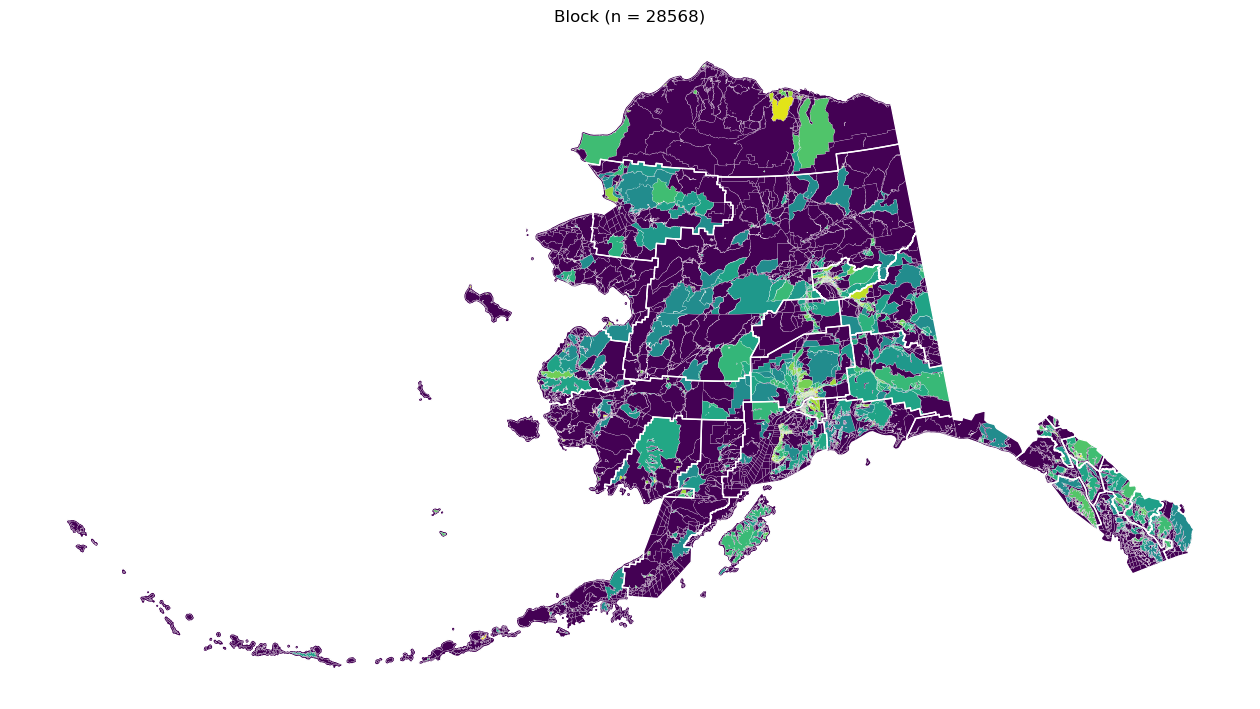

In [17]:
# visualize blocks
blocks['log_pop'] = np.log(blocks.totalpop+0.001)
fig, ax = plt.subplots(figsize=(16, 9))
blocks.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor = 'white', lw = 0.1)
boroughs.plot(ax = ax, facecolor='none', edgecolor='white')
ax.set_axis_off()
plt.title("Block (n = %s)" % len(blocks))
#plt.savefig('../Output/Figures/blocks.png', dpi=1200)

In [8]:
## Investigate the difference between Alan's city CSV and Census places 
alan_city = pd.read_csv("../Data/city.csv")
places = gpd.read_file("../Data/shapefiles/akplaces_2010/")

In [9]:
alan_census_cities = alan_city['census_city'].str.lower()
ak_places = places['NAME'].str.lower()

In [10]:
ak_places

0      sand point city
1       king cove city
2      false pass city
3        cold bay city
4          akutan city
            ...       
350    stony river cdp
351       tuluksak cdp
352    tuntutuliak cdp
353        tununak cdp
354      mertarvik cdp
Name: NAME, Length: 355, dtype: object

In [11]:
alan_census_cities

0      anchorage municipality
1                   adak city
2                 akutan city
3              allakaket city
4                 angoon city
                ...          
272           wainwright city
273            fairbanks city
274                newtok cdp
275             point lay cdp
276              chignik city
Name: census_city, Length: 277, dtype: object

In [12]:
alan_census_cities.isin(ak_places).mean()

1.0

### Computation of populations at different levels

In [44]:
places_pop = places['totalpop'].sum()

In [45]:
blocks_pop = blocks['totalpop'].sum()

In [46]:
places_pop

716681.0

In [42]:
blocks_pop

733391.0

In [40]:
blocks_pop - places_pop

16710.0

In [39]:
(blocks_pop - places_pop)/blocks_pop * 100

2.2784571940479226

In [37]:
zero_blocks = blocks['totalpop'] == 0
zero_blocks.mean()

0.5881755810697283

In [47]:
len(blocks)

28568